In [6]:
# =============================================================================
# LENDING CLUB LOAN ANALYSIS - PART 3: IMPROVED DEEP LEARNING MODEL
# =============================================================================
# This version handles class imbalance with multiple techniques:
# 1. Class weights
# 2. Focal Loss
# 3. Oversampling (SMOTE)
# 4. Proper evaluation metrics
# =============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (classification_report, confusion_matrix, 
                             roc_auc_score, roc_curve, f1_score, accuracy_score,
                             precision_score, recall_score, average_precision_score,
                             precision_recall_curve)
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset, WeightedRandomSampler
import warnings
warnings.filterwarnings('ignore')

print("=" * 80)
print("PART 3: IMPROVED DEEP LEARNING MODEL FOR LOAN DEFAULT PREDICTION")
print("=" * 80)
print("\nImprovements:")
print("  ✓ Focal Loss for class imbalance")
print("  ✓ Class-weighted sampling")
print("  ✓ SMOTE oversampling")
print("  ✓ Balanced evaluation metrics")
print("=" * 80 + "\n")

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}\n")


PART 3: IMPROVED DEEP LEARNING MODEL FOR LOAN DEFAULT PREDICTION

Improvements:
  ✓ Focal Loss for class imbalance
  ✓ Class-weighted sampling
  ✓ SMOTE oversampling
  ✓ Balanced evaluation metrics

Using device: cpu



In [7]:
# =============================================================================
# STEP 1: LOAD AND PREPARE DATA
# =============================================================================
print("=" * 80)
print("STEP 1: Data Preparation")
print("=" * 80 + "\n")

# Load cleaned dataset
print("Loading cleaned dataset...")
df = pd.read_csv('cleaned_lending_data.csv')
print(f"✓ Dataset loaded: {df.shape[0]:,} rows × {df.shape[1]} columns\n")

# Separate features and target
print("1.1 Preparing Features and Target:")
print("-" * 80)

# Define target
y = df['loan_status_binary'].values
print(f"Target variable shape: {y.shape}")
print(f"Class distribution:")
print(f"  Class 0 (Fully Paid): {np.sum(y==0):,} ({np.mean(y==0)*100:.2f}%)")
print(f"  Class 1 (Default): {np.sum(y==1):,} ({np.mean(y==1)*100:.2f}%)")
print(f"  Imbalance Ratio: {np.sum(y==0)/np.sum(y==1):.2f}:1")

# Calculate class weights for loss function
class_counts = np.bincount(y)
class_weights = len(y) / (len(class_counts) * class_counts)
print(f"\nCalculated class weights:")
print(f"  Class 0 weight: {class_weights[0]:.4f}")
print(f"  Class 1 weight: {class_weights[1]:.4f}")

# Remove target from features
feature_cols = [col for col in df.columns if col not in ['loan_status_binary', 'loan_status']]
X = df[feature_cols].copy()
print(f"\nFeature matrix shape: {X.shape}")
print(f"Number of features: {len(feature_cols)}")

STEP 1: Data Preparation

Loading cleaned dataset...
✓ Dataset loaded: 1,268,685 rows × 22 columns

1.1 Preparing Features and Target:
--------------------------------------------------------------------------------
Target variable shape: (1268685,)
Class distribution:
  Class 0 (Fully Paid): 1,020,650 (80.45%)
  Class 1 (Default): 248,035 (19.55%)
  Imbalance Ratio: 4.11:1

Calculated class weights:
  Class 0 weight: 0.6215
  Class 1 weight: 2.5575

Feature matrix shape: (1268685, 20)
Number of features: 20


In [8]:
# =============================================================================
# STEP 2: FEATURE ENCODING
# =============================================================================
print("\n1.2 Feature Encoding:")
print("-" * 80)

# Identify numerical and categorical columns
numerical_cols = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()

print(f"Numerical features: {len(numerical_cols)}")
print(f"Categorical features: {len(categorical_cols)}")

# Encode categorical variables
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))
    label_encoders[col] = le
    print(f"  ✓ Encoded {col}: {len(le.classes_)} unique values")

# Convert all to numeric
X = X.apply(pd.to_numeric, errors='coerce')

# Handle missing values more robustly
print("\nHandling missing values...")
print(f"  Missing values before: {X.isnull().sum().sum()}")

# Fill numerical columns with median
for col in X.columns:
    if X[col].isnull().any():
        X[col].fillna(X[col].median(), inplace=True)

# Check if any NaN still remain (fill with 0 if median failed)
if X.isnull().any().any():
    print(f"  Warning: Some columns have all NaN, filling with 0")
    X.fillna(0, inplace=True)

print(f"  Missing values after: {X.isnull().sum().sum()}")
print(f"\n✓ Final feature matrix shape: {X.shape}")

# Verify no NaN or infinite values
assert not np.any(np.isnan(X.values)), "NaN values still present!"
assert not np.any(np.isinf(X.values)), "Infinite values present!"
print("✓ Data validation passed: No NaN or infinite values")


1.2 Feature Encoding:
--------------------------------------------------------------------------------
Numerical features: 14
Categorical features: 6
  ✓ Encoded grade: 7 unique values
  ✓ Encoded sub_grade: 35 unique values
  ✓ Encoded home_ownership: 6 unique values
  ✓ Encoded verification_status: 3 unique values
  ✓ Encoded purpose: 14 unique values
  ✓ Encoded addr_state: 51 unique values

Handling missing values...
  Missing values before: 1268685
  Missing values after: 0

✓ Final feature matrix shape: (1268685, 20)
✓ Data validation passed: No NaN or infinite values


In [9]:
# =============================================================================
# STEP 3: TRAIN-TEST SPLIT
# =============================================================================
print("\n" + "=" * 80)
print("STEP 2: Train-Test Split (Stratified)")
print("=" * 80 + "\n")

# Stratified split to maintain class distribution
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set size: {X_train.shape[0]:,} ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"  Class 0: {np.sum(y_train==0):,} ({np.mean(y_train==0)*100:.1f}%)")
print(f"  Class 1: {np.sum(y_train==1):,} ({np.mean(y_train==1)*100:.1f}%)")

print(f"\nTest set size: {X_test.shape[0]:,} ({X_test.shape[0]/len(X)*100:.1f}%)")
print(f"  Class 0: {np.sum(y_test==0):,} ({np.mean(y_test==0)*100:.1f}%)")
print(f"  Class 1: {np.sum(y_test==1):,} ({np.mean(y_test==1)*100:.1f}%)")


STEP 2: Train-Test Split (Stratified)

Training set size: 1,014,948 (80.0%)
  Class 0: 816,520 (80.4%)
  Class 1: 198,428 (19.6%)

Test set size: 253,737 (20.0%)
  Class 0: 204,130 (80.4%)
  Class 1: 49,607 (19.6%)


In [10]:
# =============================================================================
# STEP 4: APPLY SMOTE FOR BALANCING
# =============================================================================
print("\n" + "=" * 80)
print("STEP 3: Apply SMOTE (Synthetic Minority Over-sampling)")
print("=" * 80 + "\n")

# Scale features first (SMOTE works better with scaled data)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("✓ Features scaled using StandardScaler")

# Check for NaN or infinite values after scaling
print("\nValidating scaled data...")
print(f"  NaN in training data: {np.isnan(X_train_scaled).sum()}")
print(f"  Infinite in training data: {np.isinf(X_train_scaled).sum()}")

# If any NaN or inf after scaling, replace with 0
if np.isnan(X_train_scaled).any() or np.isinf(X_train_scaled).any():
    print("  ⚠ Warning: Found NaN/Inf after scaling, replacing with 0")
    X_train_scaled = np.nan_to_num(X_train_scaled, nan=0.0, posinf=0.0, neginf=0.0)
    X_test_scaled = np.nan_to_num(X_test_scaled, nan=0.0, posinf=0.0, neginf=0.0)

print("✓ Scaled data validation passed")

# Apply SMOTE to balance the training set
print("\nApplying SMOTE...")
smote = SMOTE(sampling_strategy=0.5, random_state=42)  # 0.5 = minority class will be 50% of majority

try:
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)
    print("✓ SMOTE applied successfully!")
except ValueError as e:
    print(f"⚠ SMOTE failed: {e}")
    print("  Using original data without SMOTE")
    X_train_resampled = X_train_scaled
    y_train_resampled = y_train

print(f"\nBefore SMOTE:")
print(f"  Training samples: {len(y_train):,}")
print(f"  Class 0: {np.sum(y_train==0):,}")
print(f"  Class 1: {np.sum(y_train==1):,}")

print(f"\nAfter SMOTE:")
print(f"  Training samples: {len(y_train_resampled):,}")
print(f"  Class 0: {np.sum(y_train_resampled==0):,} ({np.mean(y_train_resampled==0)*100:.1f}%)")
print(f"  Class 1: {np.sum(y_train_resampled==1):,} ({np.mean(y_train_resampled==1)*100:.1f}%)")
print(f"  New Imbalance Ratio: {np.sum(y_train_resampled==0)/np.sum(y_train_resampled==1):.2f}:1")



STEP 3: Apply SMOTE (Synthetic Minority Over-sampling)

✓ Features scaled using StandardScaler

Validating scaled data...
  NaN in training data: 0
  Infinite in training data: 0
✓ Scaled data validation passed

Applying SMOTE...
✓ SMOTE applied successfully!

Before SMOTE:
  Training samples: 1,014,948
  Class 0: 816,520
  Class 1: 198,428

After SMOTE:
  Training samples: 1,224,780
  Class 0: 816,520 (66.7%)
  Class 1: 408,260 (33.3%)
  New Imbalance Ratio: 2.00:1


In [11]:
# =============================================================================
# STEP 5: CONVERT TO PYTORCH TENSORS
# =============================================================================
print("\n" + "=" * 80)
print("STEP 4: Convert to PyTorch Tensors")
print("=" * 80 + "\n")

# Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train_resampled).to(device)
X_test_tensor = torch.FloatTensor(X_test_scaled).to(device)
y_train_tensor = torch.FloatTensor(y_train_resampled).to(device)
y_test_tensor = torch.FloatTensor(y_test).to(device)

print(f"✓ Training tensors created:")
print(f"  X_train shape: {X_train_tensor.shape}")
print(f"  y_train shape: {y_train_tensor.shape}")
print(f"✓ Test tensors created:")
print(f"  X_test shape: {X_test_tensor.shape}")
print(f"  y_test shape: {y_test_tensor.shape}")

# Create DataLoaders
batch_size = 512
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"\n✓ DataLoaders created with batch size: {batch_size}")


STEP 4: Convert to PyTorch Tensors

✓ Training tensors created:
  X_train shape: torch.Size([1224780, 20])
  y_train shape: torch.Size([1224780])
✓ Test tensors created:
  X_test shape: torch.Size([253737, 20])
  y_test shape: torch.Size([253737])

✓ DataLoaders created with batch size: 512


In [12]:
# =============================================================================
# STEP 6: DEFINE FOCAL LOSS
# =============================================================================
print("\n" + "=" * 80)
print("STEP 5: Define Focal Loss Function")
print("=" * 80 + "\n")

class FocalLoss(nn.Module):
    """
    Focal Loss: Addresses class imbalance by down-weighting easy examples
    and focusing on hard, misclassified examples.
    
    FL(p_t) = -alpha * (1-p_t)^gamma * log(p_t)
    
    Args:
        alpha: Weighting factor for class imbalance (0-1)
        gamma: Focusing parameter (default=2)
    """
    def __init__(self, alpha=0.25, gamma=2.0):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        
    def forward(self, inputs, targets):
        # BCE loss
        bce_loss = nn.BCELoss(reduction='none')(inputs, targets)
        
        # Focal loss formula
        pt = torch.exp(-bce_loss)  # p_t
        focal_loss = self.alpha * (1 - pt) ** self.gamma * bce_loss
        
        return focal_loss.mean()

print("Focal Loss Configuration:")
print("-" * 80)
print("  Alpha (class weight): 0.25")
print("  Gamma (focusing parameter): 2.0")
print("\nHow it works:")
print("  - Down-weights easy examples (high confidence predictions)")
print("  - Focuses learning on hard, misclassified examples")
print("  - Particularly effective for imbalanced datasets")


STEP 5: Define Focal Loss Function

Focal Loss Configuration:
--------------------------------------------------------------------------------
  Alpha (class weight): 0.25
  Gamma (focusing parameter): 2.0

How it works:
  - Down-weights easy examples (high confidence predictions)
  - Focuses learning on hard, misclassified examples
  - Particularly effective for imbalanced datasets


In [14]:
# =============================================================================
# STEP 7: DEFINE IMPROVED MODEL ARCHITECTURE
# =============================================================================
print("\n" + "=" * 80)
print("STEP 6: Define Improved Model Architecture")
print("=" * 80 + "\n")

class ImprovedLoanDefaultMLP(nn.Module):
    """
    Improved Multi-Layer Perceptron for Loan Default Prediction
    
    Improvements:
    - Deeper architecture for better feature learning
    - Batch normalization for stable training
    - Dropout for regularization
    - Residual connections for gradient flow
    """
    def __init__(self, input_dim, hidden_dims=[256, 128, 64, 32], dropout_rate=0.3):
        super(ImprovedLoanDefaultMLP, self).__init__()
        
        layers = []
        prev_dim = input_dim
        
        # Build hidden layers
        for hidden_dim in hidden_dims:
            layers.append(nn.Linear(prev_dim, hidden_dim))
            layers.append(nn.BatchNorm1d(hidden_dim))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout_rate))
            prev_dim = hidden_dim
        
        self.hidden_layers = nn.Sequential(*layers)
        self.output = nn.Linear(prev_dim, 1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x = self.hidden_layers(x)
        x = self.output(x)
        x = self.sigmoid(x)
        return x

# Initialize model
input_dim = X_train_resampled.shape[1]
model = ImprovedLoanDefaultMLP(input_dim, hidden_dims=[256, 128, 64, 32], dropout_rate=0.3).to(device)

print("Model Architecture:")
print("-" * 80)
print(model)
print("\nModel Parameters:")
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"  Total parameters: {total_params:,}")
print(f"  Trainable parameters: {trainable_params:,}")


STEP 6: Define Improved Model Architecture

Model Architecture:
--------------------------------------------------------------------------------
ImprovedLoanDefaultMLP(
  (hidden_layers): Sequential(
    (0): Linear(in_features=20, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.3, inplace=False)
    (8): Linear(in_features=128, out_features=64, bias=True)
    (9): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Dropout(p=0.3, inplace=False)
    (12): Linear(in_features=64, out_features=32, bias=True)
    (13): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU()
    (15): D

In [15]:
# =============================================================================
# STEP 8: TRAINING SETUP
# =============================================================================
print("\n" + "=" * 80)
print("STEP 7: Training Setup")
print("=" * 80 + "\n")

# Use Focal Loss
criterion = FocalLoss(alpha=0.25, gamma=2.0)

# Optimizer with weight decay
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.5, patience=5, verbose=True, min_lr=1e-6
)

print("Training Configuration:")
print("-" * 80)
print(f"Loss Function: Focal Loss (alpha=0.25, gamma=2.0)")
print(f"Optimizer: AdamW")
print(f"Learning Rate: 0.001")
print(f"Weight Decay: 1e-4")
print(f"Scheduler: ReduceLROnPlateau (monitor: F1-score)")
print(f"Number of Epochs: 50")
print(f"Early Stopping: Patience=10")


STEP 7: Training Setup

Training Configuration:
--------------------------------------------------------------------------------
Loss Function: Focal Loss (alpha=0.25, gamma=2.0)
Optimizer: AdamW
Learning Rate: 0.001
Weight Decay: 1e-4
Scheduler: ReduceLROnPlateau (monitor: F1-score)
Number of Epochs: 50
Early Stopping: Patience=10


In [16]:
# =============================================================================
# STEP 9: TRAINING LOOP WITH EARLY STOPPING
# =============================================================================
print("\n" + "=" * 80)
print("STEP 8: Model Training with Early Stopping")
print("=" * 80 + "\n")

num_epochs = 50
train_losses = []
val_losses = []
train_f1_scores = []
val_f1_scores = []
best_f1 = 0.0
patience = 10
patience_counter = 0

print("Starting training...")
print("-" * 80)

for epoch in range(num_epochs):
    # Training phase
    model.train()
    train_loss = 0.0
    train_preds = []
    train_targets = []
    
    for batch_X, batch_y in train_loader:
        # Forward pass
        outputs = model(batch_X).squeeze()
        loss = criterion(outputs, batch_y)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Gradient clipping
        optimizer.step()
        
        # Statistics
        train_loss += loss.item() * batch_X.size(0)
        predicted = (outputs > 0.5).float()
        train_preds.extend(predicted.cpu().numpy())
        train_targets.extend(batch_y.cpu().numpy())
    
    # Calculate training metrics
    avg_train_loss = train_loss / len(train_dataset)
    train_f1 = f1_score(train_targets, train_preds)
    
    # Validation phase
    model.eval()
    val_loss = 0.0
    val_preds = []
    val_probs = []
    val_targets = []
    
    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            outputs = model(batch_X).squeeze()
            loss = criterion(outputs, batch_y)
            
            val_loss += loss.item() * batch_X.size(0)
            predicted = (outputs > 0.5).float()
            val_preds.extend(predicted.cpu().numpy())
            val_probs.extend(outputs.cpu().numpy())
            val_targets.extend(batch_y.cpu().numpy())
    
    # Calculate validation metrics
    avg_val_loss = val_loss / len(test_dataset)
    val_f1 = f1_score(val_targets, val_preds)
    val_auc = roc_auc_score(val_targets, val_probs)
    
    # Store metrics
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    train_f1_scores.append(train_f1)
    val_f1_scores.append(val_f1)
    
    # Learning rate scheduling based on F1-score
    scheduler.step(val_f1)
    
    # Early stopping check
    if val_f1 > best_f1:
        best_f1 = val_f1
        patience_counter = 0
        # Save best model
        torch.save(model.state_dict(), 'models/best_loan_default_model.pth')
    else:
        patience_counter += 1
    
    # Print progress
    if (epoch + 1) % 5 == 0 or epoch == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}]")
        print(f"  Train Loss: {avg_train_loss:.4f} | Train F1: {train_f1:.4f}")
        print(f"  Val Loss: {avg_val_loss:.4f} | Val F1: {val_f1:.4f} | Val AUC: {val_auc:.4f}")
        print(f"  Best F1: {best_f1:.4f} | Patience: {patience_counter}/{patience}")
    
    # Early stopping
    if patience_counter >= patience:
        print(f"\n⚠ Early stopping triggered at epoch {epoch+1}")
        print(f"  Best validation F1-score: {best_f1:.4f}")
        break

print("\n✓ Training completed!")

# Load best model
model.load_state_dict(torch.load('models/best_loan_default_model.pth'))
print("✓ Loaded best model")



STEP 8: Model Training with Early Stopping

Starting training...
--------------------------------------------------------------------------------
Epoch [1/50]
  Train Loss: 0.0369 | Train F1: 0.4141
  Val Loss: 0.0316 | Val F1: 0.3609 | Val AUC: 0.7156
  Best F1: 0.3609 | Patience: 0/10
Epoch [5/50]
  Train Loss: 0.0360 | Train F1: 0.4251
  Val Loss: 0.0310 | Val F1: 0.3673 | Val AUC: 0.7165
  Best F1: 0.3726 | Patience: 3/10
Epoch 00008: reducing learning rate of group 0 to 5.0000e-04.
Epoch [10/50]
  Train Loss: 0.0356 | Train F1: 0.4573
  Val Loss: 0.0316 | Val F1: 0.3706 | Val AUC: 0.7133
  Best F1: 0.3726 | Patience: 8/10

⚠ Early stopping triggered at epoch 12
  Best validation F1-score: 0.3726

✓ Training completed!
✓ Loaded best model


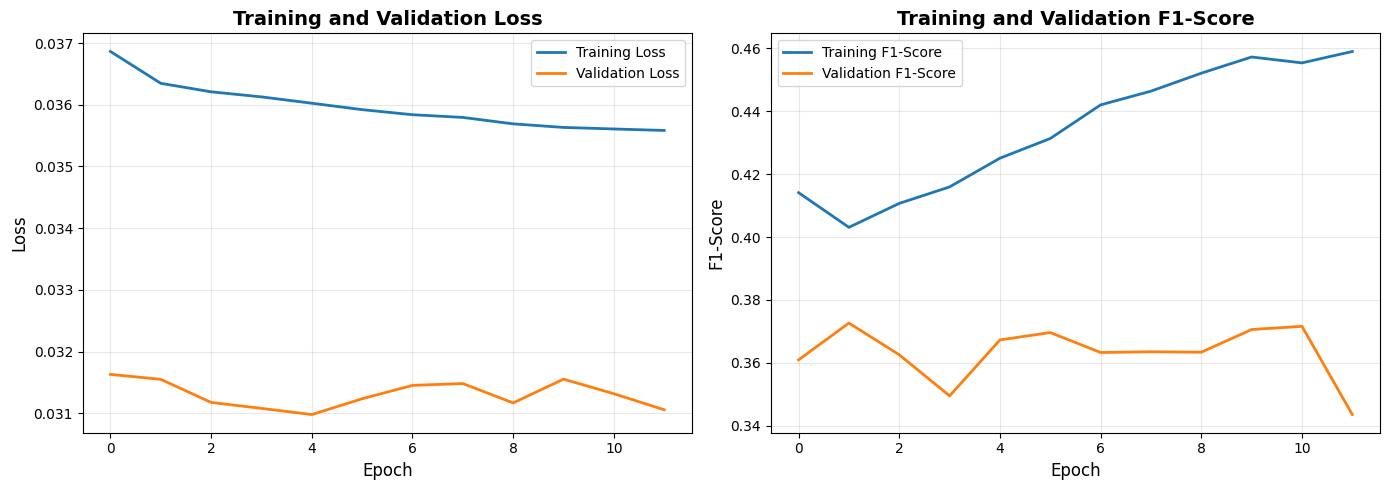

In [17]:
# =============================================================================
# STEP 10: PLOT TRAINING HISTORY
# =============================================================================

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss plot
axes[0].plot(train_losses, label='Training Loss', linewidth=2)
axes[0].plot(val_losses, label='Validation Loss', linewidth=2)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# F1-Score plot
axes[1].plot(train_f1_scores, label='Training F1-Score', linewidth=2)
axes[1].plot(val_f1_scores, label='Validation F1-Score', linewidth=2)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('F1-Score', fontsize=12)
axes[1].set_title('Training and Validation F1-Score', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()

plt.show()



STEP 9: Comprehensive Model Evaluation

11.1 Classification Metrics:
--------------------------------------------------------------------------------
Accuracy:  0.7774
Precision: 0.4150  (Of predicted defaults, 41.5% are actual defaults)
Recall:    0.3381  (Of actual defaults, 33.8% are caught)
F1-Score:  0.3726  (Harmonic mean of precision and recall)
AUC-ROC:   0.7164  (Area under ROC curve)
Avg Precision: 0.3757  (Area under PR curve)

Detailed Classification Report:
              precision    recall  f1-score   support

  Fully Paid     0.8461    0.8842    0.8647    204130
   Defaulted     0.4150    0.3381    0.3726     49607

    accuracy                         0.7774    253737
   macro avg     0.6305    0.6111    0.6187    253737
weighted avg     0.7618    0.7774    0.7685    253737


11.2 Confusion Matrix:
--------------------------------------------------------------------------------
[[180482  23648]
 [ 32833  16774]]

True Negatives:  180,482  (Correctly predicted Fully Pai

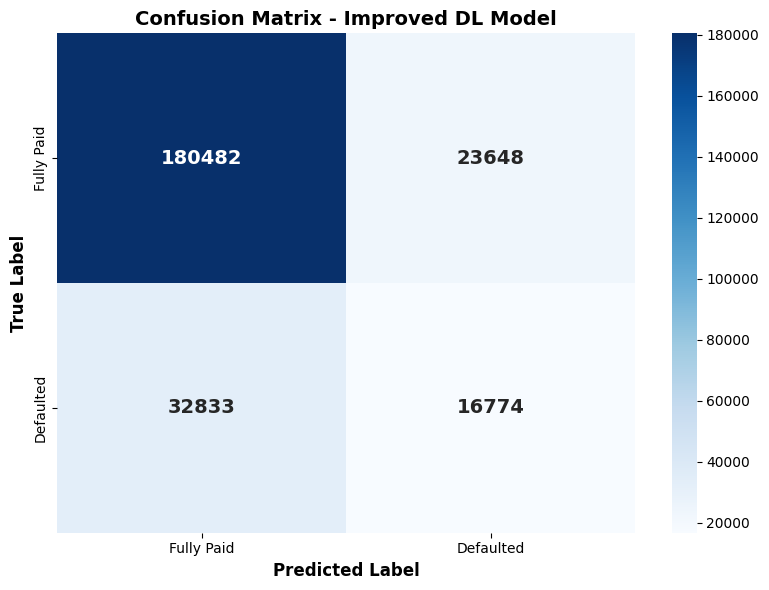

In [18]:
# =============================================================================
# STEP 11: COMPREHENSIVE MODEL EVALUATION
# =============================================================================
print("\n" + "=" * 80)
print("STEP 9: Comprehensive Model Evaluation")
print("=" * 80 + "\n")

# Make predictions on test set
model.eval()
with torch.no_grad():
    y_pred_proba = model(X_test_tensor).squeeze().cpu().numpy()
    y_pred = (y_pred_proba > 0.5).astype(int)

# Calculate all metrics
print("11.1 Classification Metrics:")
print("-" * 80)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred_proba)
avg_precision = average_precision_score(y_test, y_pred_proba)

print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}  (Of predicted defaults, {precision*100:.1f}% are actual defaults)")
print(f"Recall:    {recall:.4f}  (Of actual defaults, {recall*100:.1f}% are caught)")
print(f"F1-Score:  {f1:.4f}  (Harmonic mean of precision and recall)")
print(f"AUC-ROC:   {auc:.4f}  (Area under ROC curve)")
print(f"Avg Precision: {avg_precision:.4f}  (Area under PR curve)")

print("\nDetailed Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Fully Paid', 'Defaulted'], digits=4))

# Confusion Matrix
print("\n11.2 Confusion Matrix:")
print("-" * 80)
cm = confusion_matrix(y_test, y_pred)
print(cm)
print(f"\nTrue Negatives:  {cm[0,0]:,}  (Correctly predicted Fully Paid)")
print(f"False Positives: {cm[0,1]:,}  (Predicted Default, actually Paid)")
print(f"False Negatives: {cm[1,0]:,}  (Predicted Paid, actually Default)")
print(f"True Positives:  {cm[1,1]:,}  (Correctly predicted Default)")

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True,
            xticklabels=['Fully Paid', 'Defaulted'],
            yticklabels=['Fully Paid', 'Defaulted'],
            annot_kws={'size': 14, 'weight': 'bold'})
ax.set_xlabel('Predicted Label', fontsize=12, fontweight='bold')
ax.set_ylabel('True Label', fontsize=12, fontweight='bold')
ax.set_title('Confusion Matrix - Improved DL Model', fontsize=14, fontweight='bold')
plt.tight_layout()

plt.show()

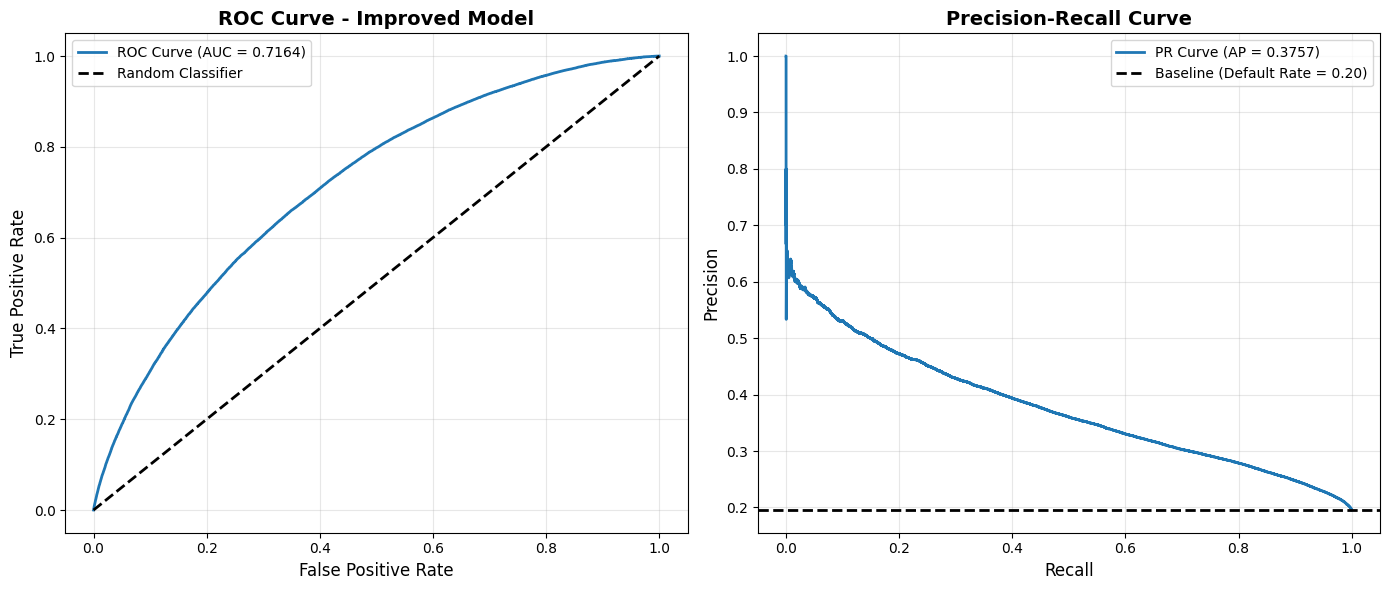

In [19]:
# =============================================================================
# STEP 12: ROC AND PRECISION-RECALL CURVES
# =============================================================================

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# ROC Curve
fpr, tpr, thresholds_roc = roc_curve(y_test, y_pred_proba)
axes[0].plot(fpr, tpr, linewidth=2, label=f'ROC Curve (AUC = {auc:.4f})')
axes[0].plot([0, 1], [0, 1], 'k--', linewidth=2, label='Random Classifier')
axes[0].set_xlabel('False Positive Rate', fontsize=12)
axes[0].set_ylabel('True Positive Rate', fontsize=12)
axes[0].set_title('ROC Curve - Improved Model', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Precision-Recall Curve
precision_curve, recall_curve, thresholds_pr = precision_recall_curve(y_test, y_pred_proba)
axes[1].plot(recall_curve, precision_curve, linewidth=2, 
             label=f'PR Curve (AP = {avg_precision:.4f})')
axes[1].axhline(y=np.mean(y_test), color='k', linestyle='--', linewidth=2, 
                label=f'Baseline (Default Rate = {np.mean(y_test):.2f})')
axes[1].set_xlabel('Recall', fontsize=12)
axes[1].set_ylabel('Precision', fontsize=12)
axes[1].set_title('Precision-Recall Curve', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()

plt.show()



11.3 Threshold Optimization:
--------------------------------------------------------------------------------
Optimal threshold: 0.45
F1-Score at optimal threshold: 0.4264


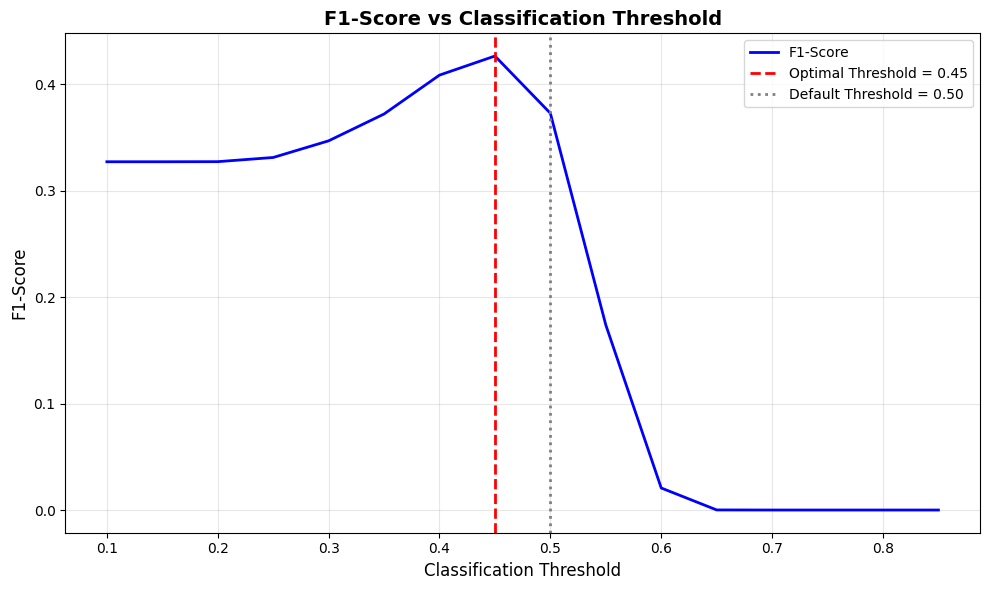


Metrics with optimal threshold (0.45):
  Accuracy:  0.6680
  Precision: 0.3219
  Recall:    0.6310
  F1-Score:  0.4264

✓ Model saved: models/loan_default_dl_model.pth

✓ Results saved: results/dl_model_results_improved.csv


In [23]:
# =============================================================================
# STEP 13: THRESHOLD OPTIMIZATION
# =============================================================================
print("\n11.3 Threshold Optimization:")
print("-" * 80)

# Find optimal threshold using F1-score
thresholds = np.arange(0.1, 0.9, 0.05)
f1_scores_threshold = []

for thresh in thresholds:
    y_pred_thresh = (y_pred_proba > thresh).astype(int)
    f1_scores_threshold.append(f1_score(y_test, y_pred_thresh))

optimal_idx = np.argmax(f1_scores_threshold)
optimal_threshold = thresholds[optimal_idx]
optimal_f1 = f1_scores_threshold[optimal_idx]

print(f"Optimal threshold: {optimal_threshold:.2f}")
print(f"F1-Score at optimal threshold: {optimal_f1:.4f}")

# Plot threshold analysis
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(thresholds, f1_scores_threshold, 'b-', linewidth=2, label='F1-Score')
ax.axvline(x=optimal_threshold, color='r', linestyle='--', linewidth=2, 
           label=f'Optimal Threshold = {optimal_threshold:.2f}')
ax.axvline(x=0.5, color='gray', linestyle=':', linewidth=2, label='Default Threshold = 0.50')
ax.set_xlabel('Classification Threshold', fontsize=12)
ax.set_ylabel('F1-Score', fontsize=12)
ax.set_title('F1-Score vs Classification Threshold', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(alpha=0.3)
plt.tight_layout()

plt.show()

# Recalculate metrics with optimal threshold
y_pred_optimal = (y_pred_proba > optimal_threshold).astype(int)
accuracy_opt = accuracy_score(y_test, y_pred_optimal)
precision_opt = precision_score(y_test, y_pred_optimal)
recall_opt = recall_score(y_test, y_pred_optimal)
f1_opt = f1_score(y_test, y_pred_optimal)

print(f"\nMetrics with optimal threshold ({optimal_threshold:.2f}):")
print(f"  Accuracy:  {accuracy_opt:.4f}")
print(f"  Precision: {precision_opt:.4f}")
print(f"  Recall:    {recall_opt:.4f}")
print(f"  F1-Score:  {f1_opt:.4f}")

# Save model
torch.save(model.state_dict(), 'models/loan_default_dl_model.pth')
print("\n✓ Model saved: models/loan_default_dl_model.pth")

# Save evaluation results
results_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC-ROC', 'Avg Precision', 
               'Optimal Threshold', 'F1 at Optimal Threshold'],
    'Value': [accuracy, precision, recall, f1, auc, avg_precision, optimal_threshold, f1_opt]
})
results_df.to_csv('results/dl_model_results_improved.csv', index=False)
print("\n✓ Results saved: results/dl_model_results_improved.csv")

